In [1]:
from google.colab import files
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import io

In [2]:
uploaded = files.upload()
filename = next(iter(uploaded))
df = pd.read_csv(io.BytesIO(uploaded[filename]))

Saving cleaned combined housing data.csv to cleaned combined housing data.csv


In [3]:
# Shape and first 5 rows
print(f"Shape: {df.shape}")
print(df.head())

# Data types
print("\n=== Data Types ===")
print(df.dtypes)

#  Missing values
print("\n=== Missing Values ===")
print(df.isnull().sum())

# Descriptive statistics
print("\n=== Descriptive Statistics ===")
print(df.describe(include='all'))

Shape: (2919, 77)
   MSSubClass MSZoning  LotArea  Street LotShape LandContour Utilities  \
0          20       RH    11622       1      Reg         Lvl    AllPub   
1          20       RL    14267       1      IR1         Lvl    AllPub   
2          60       RL    13830       1      IR1         Lvl    AllPub   
3          60       RL     9978       1      IR1         Lvl    AllPub   
4         120       RL     5005       1      IR1         HLS    AllPub   

  LotConfig LandSlope Neighborhood  ... PoolArea MiscVal MoSold YrSold  \
0    Inside       Gtl        NAmes  ...        0       0      6   2010   
1    Corner       Gtl        NAmes  ...        0   12500      6   2010   
2    Inside       Gtl      Gilbert  ...        0       0      3   2010   
3    Inside       Gtl      Gilbert  ...        0       0      6   2010   
4    Inside       Gtl      StoneBr  ...        0       0      1   2010   

   SaleType  SaleCondition  SalePrice  HouseAge TotalBath TotalSF  
0        WD         Norm

In [4]:
df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']
df['AgeAtSale'] = df['YrSold'] - df['YearBuilt']
df['RemodAge'] = df['YrSold'] - df['YearRemodAdd']
df['HasPool'] = df['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
df['TotalBath'] = df['FullBath'] + 0.5*df['HalfBath'] + df['BsmtFullBath'] + 0.5*df['BsmtHalfBath']

In [5]:
X = df.drop(['SalePrice', 'Id'], axis=1, errors='ignore')
y = df['SalePrice']

In [6]:
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

In [8]:
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

In [9]:
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=4,
        random_state=42))])

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)


In [13]:
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['MSSubClass', 'LotArea', 'Street', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', 'CentralAir', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBat...
       'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating',
       'HeatingQC', 'Electrical', 'KitchenQual', 'Functional', 'GarageType',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'SaleType',
       'SaleCondition'],
      dtype='object'))])),
                ('regressor',
                 GradientBoostingRegressor(learning_rate=0.05, max_depth=4,
                                           n_estimators=500,
                                           random_state=42))])

In [15]:
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("\nModel Performance:")
print(f"Mean Absolute Error: ${mae:,.2f}")
print(f"R-squared Score: {r2:.4f}")



Model Performance:
Mean Absolute Error: $29,185.27
R-squared Score: 0.3706


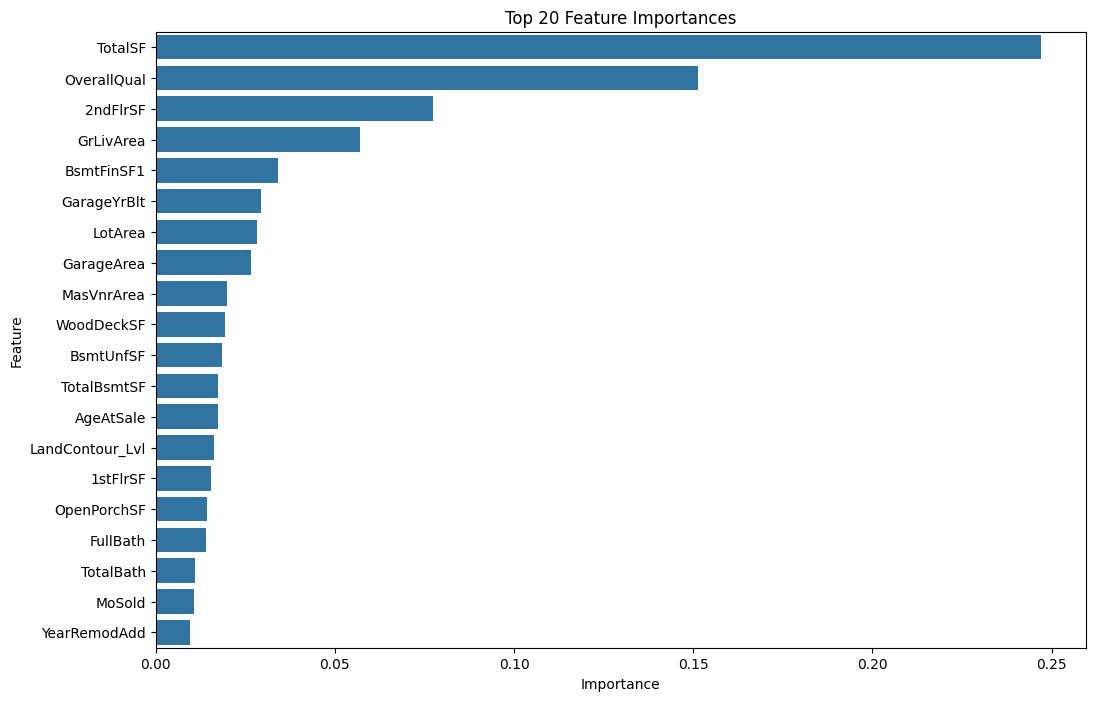

In [16]:
feature_importances = model.named_steps['regressor'].feature_importances_
cat_onehot_columns = model.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)
all_features = np.concatenate([numeric_features, cat_onehot_columns])

importance_df = pd.DataFrame({'Feature': all_features, 'Importance': feature_importances})
importance_df = importance_df.sort_values('Importance', ascending=False).head(20)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Top 20 Feature Importances')
plt.show()


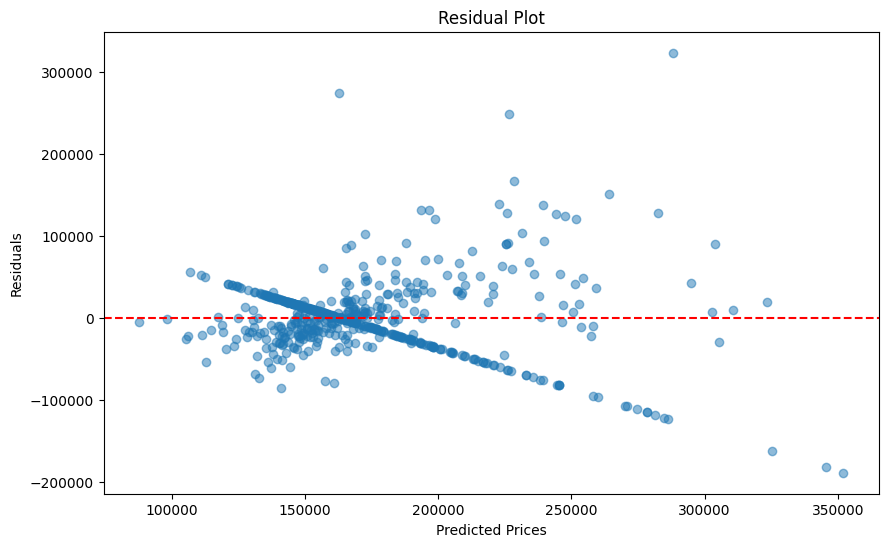

In [17]:
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Prices')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

In [ ]:
import joblib
joblib.dump(model, 'advanced_house_price_model.pkl')
files.download('advanced_house_price_model.pkl')
